In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
PROCESSED_DATA_PATH = "../Data/Processed"
OUTPUT_FIGURES_PATH = "../Output/Figures"

ENROLMENT_MONTHLY_FILE = "enrollment_monthly.csv"
DEMOGRAPHIC_MONTHLY_FILE = "demographic_monthly.csv"

os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

In [12]:
enrolment_monthly = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, ENROLMENT_MONTHLY_FILE)
)

demo_monthly = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, DEMOGRAPHIC_MONTHLY_FILE)
)

print("Enrolment Monthly Shape:", enrolment_monthly.shape)
print("Demographic Monthly Shape:", demo_monthly.shape)

enrolment_monthly.head(), demo_monthly.head()

Enrolment Monthly Shape: (5062, 7)
Demographic Monthly Shape: (6004, 6)


(     month           state      district  age_0_5  age_5_17  age_18_greater  \
 0  2025-03  Andhra Pradesh  Spsr Nellore       43        44              29   
 1  2025-03           Assam         Baksa       11        14              13   
 2  2025-03           Assam       Barpeta       24        34              10   
 3  2025-03           Assam    Bongaigaon       25        33              31   
 4  2025-03           Assam       Chirang       12        29              15   
 
    total_enrolment  
 0              116  
 1               38  
 2               68  
 3               89  
 4               56  ,
      month                        state                  district  \
 0  2025-03  Andaman and Nicobar Islands                   Nicobar   
 1  2025-03  Andaman and Nicobar Islands  North And Middle Andaman   
 2  2025-03  Andaman and Nicobar Islands             South Andaman   
 3  2025-03               Andhra Pradesh                  Adilabad   
 4  2025-03               Andhra Pr

In [13]:
enrolment_monthly['month'] = pd.to_datetime(enrolment_monthly['month'])
demo_monthly['month'] = pd.to_datetime(demo_monthly['month'])

In [14]:
def detect_anomalies(series, factor=2):
    mean = series.mean()
    std = series.std()
    threshold = mean + factor * std
    return series[series > threshold], threshold

In [15]:
national_updates = demo_monthly.groupby('month')['total_demo_updates'].sum()

anomalies_national, threshold_national = detect_anomalies(national_updates)

print("National Update Anomaly Threshold:", threshold_national)
print("Anomalous Months:")
print(anomalies_national)

National Update Anomaly Threshold: 9198196.466993451
Anomalous Months:
Series([], Name: total_demo_updates, dtype: float64)


In [16]:
district_updates = demo_monthly.groupby(
    ['district', 'month']
)['total_demo_updates'].sum().reset_index()

district_anomalies = []

for district in district_updates['district'].unique():
    temp = district_updates[district_updates['district'] == district]
    anomalies, threshold = detect_anomalies(temp['total_demo_updates'])
    
    if not anomalies.empty:
        temp_anom = temp[temp['total_demo_updates'].isin(anomalies)]
        district_anomalies.append(temp_anom)

district_anomalies_df = pd.concat(district_anomalies) if district_anomalies else pd.DataFrame()

district_anomalies_df.head()

,district,month,total_demo_updates
46,Ahmedabad,2025-03-01,49865.0
60,Ajmer,2025-03-01,38840.0
113,Alwar,2025-03-01,49008.0
190,Ananthapuramu,2025-03-01,8668.0
199,Anantnag,2025-03-01,7953.0


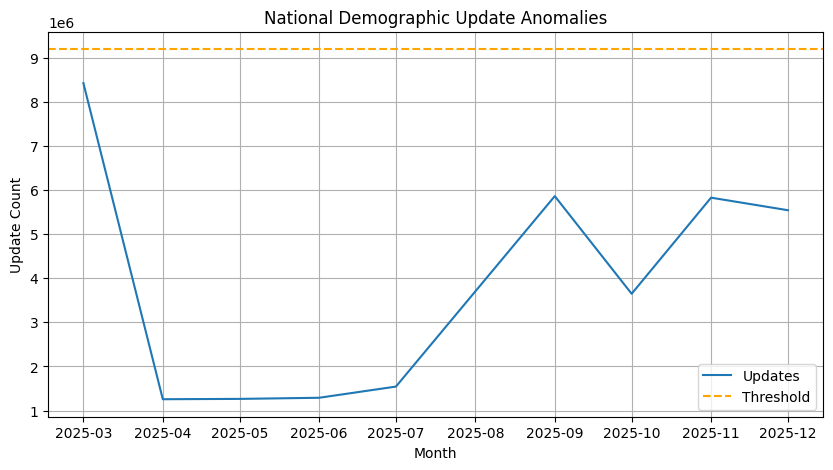

In [17]:
plt.figure(figsize=(10,5))
plt.plot(national_updates.index, national_updates.values, label="Updates")

if not anomalies_national.empty:
    plt.scatter(
        anomalies_national.index,
        anomalies_national.values,
        color='red',
        label="Anomaly"
    )

plt.axhline(threshold_national, color='orange', linestyle='--', label="Threshold")
plt.title("National Demographic Update Anomalies")
plt.xlabel("Month")
plt.ylabel("Update Count")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
plt.figure(figsize=(10,5))
plt.plot(national_updates.index, national_updates.values)
plt.axhline(threshold_national, color='red', linestyle='--')
plt.title("Demographic Update Anomaly Detection")

plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, "demographic_update_anomalies.png"))
plt.close()

print("Anomaly figure saved successfully")

Anomaly figure saved successfully
